In [1]:
from Imports import *
from Helper import *
from Preprocessing import *
from Plotting import *
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.noise = GaussianNoise(sigma=0.3)

        self.feature_gen = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 256),
            nn.LayerNorm(256),
            self.noise
        )

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat)
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 128

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([872666, 16, 16])
dR Mean: torch.Size([872666])
dR STD: torch.Size([872666])
Pixel Mean: torch.Size([872666])
Pixel STD: torch.Size([872666])
ΔR min: 0.0
ΔR max: 2.4713454246520996
ΔR mean min: 0.003572926390916109
ΔR mean max: 0.015763528645038605
ΔR std min: 0.017520317807793617
ΔR std max: 0.16022197902202606
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.004322932101786137
Pixel std min: 0.008012386038899422
Pixel std max: 0.06249340996146202


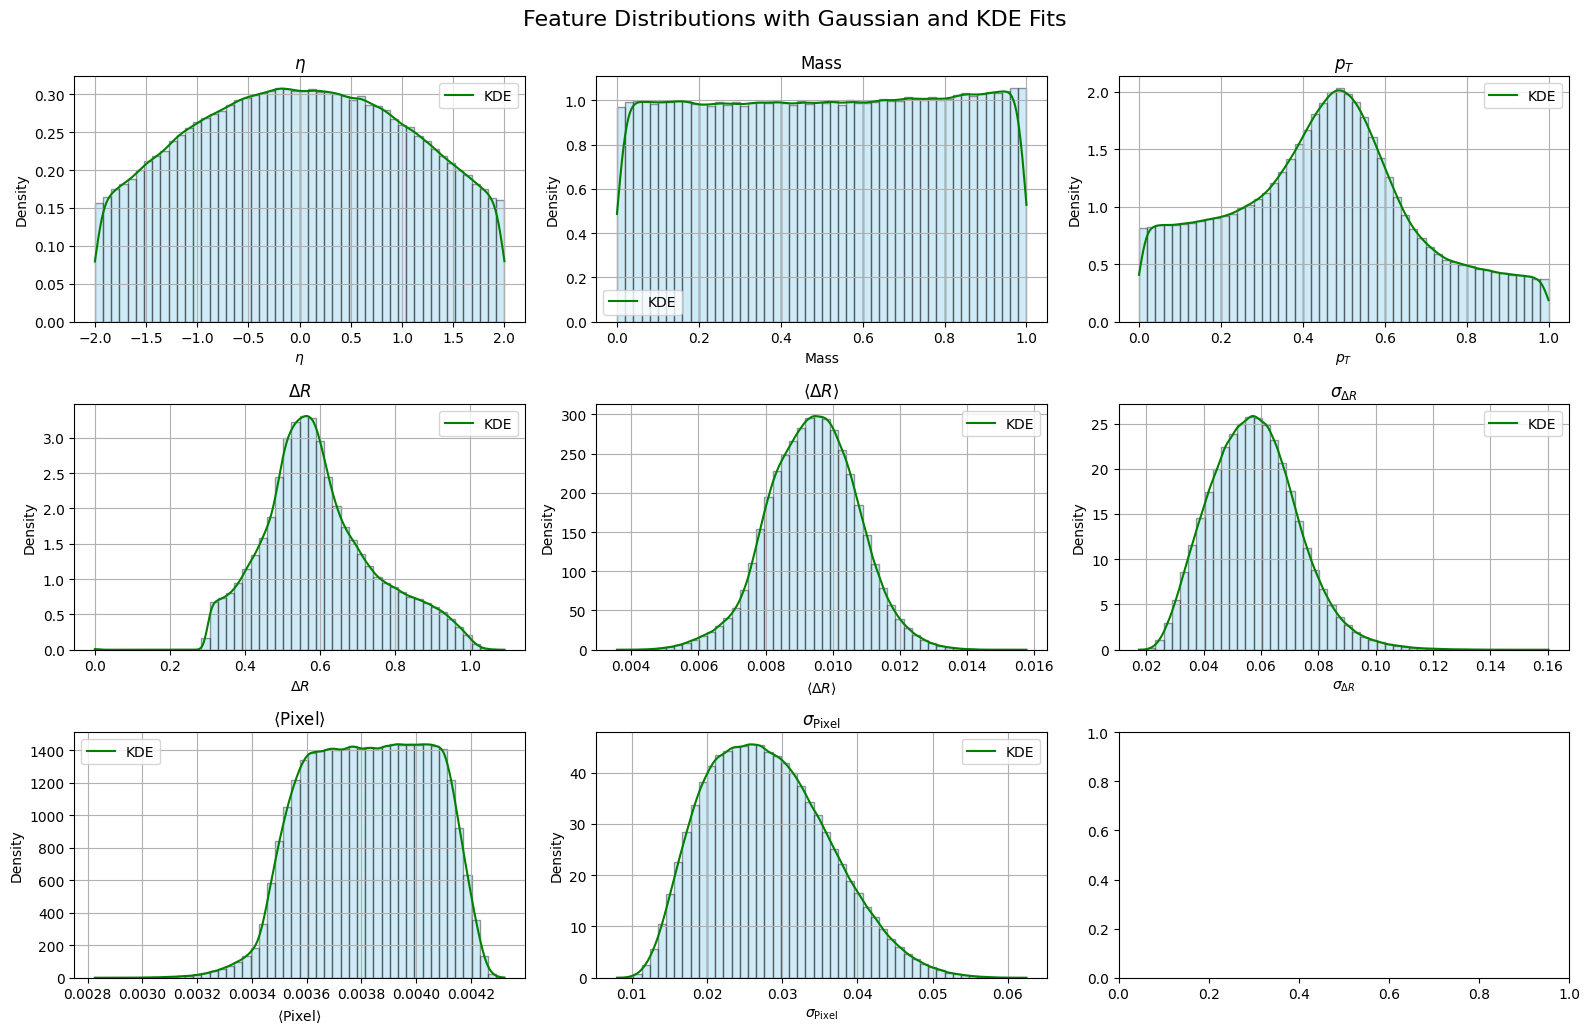

Number of samples: 872666
Image shape: torch.Size([872666, 16, 16])
Feature shape: torch.Size([872666, 9])


In [4]:
batch_size = 128*3
n_events = int(1 * jet_mass_data['image'].shape[0])

latent_dim = 256
lr = 1e-4
n_epochs = 300
num = 4

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

In [5]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=n_epochs, eta_min=1e-6)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=n_epochs, eta_min=1e-6)

g_losses = []
d_losses = []

# Tracking buffers
stats_dict = {
    'fake_dR_mean': [],
    'fake_dR_std': [],
    'fake_pixel_mean': [],
    'fake_pixel_std': [],
    'real_dR_mean': [],
    'real_dR_std': [],
    'real_pixel_mean': [],
    'real_pixel_std': []
}

dists = compute_distance_map(16,16).to(device)

In [6]:
## Load a previous model
# Replace with the desired filename
load = True

if load:
    load_path = "models/class_gan_m15_1951.pt"
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    
    # Optionally restore tracking data
    g_losses = checkpoint["g_losses"]
    d_losses = checkpoint["d_losses"]
    
    stats_dict = checkpoint["stats_dict"]
    
    print(f"Loaded model from {load_path}")

[Epoch 1/100] [D loss: 0.6315] [G loss: 1.1578] [Validity_loss: 0.6275] 
 [Stat_loss: 0.0444] [NNZ_loss: 0.4859]
Sample feature coding: [0.         1.1067773  0.0124949  0.7883515  0.3880918  0.01043539
 0.06676706 0.00367442 0.04606541]


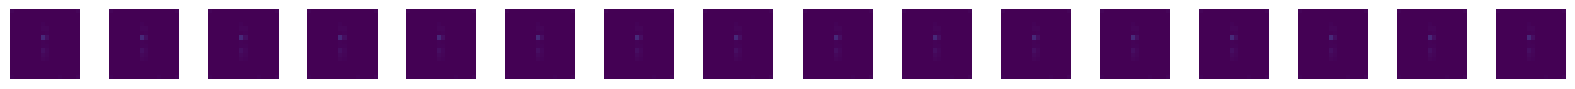

[Epoch 2/100] [D loss: 0.6880] [G loss: 1.2277] [Validity_loss: 0.5939] 
 [Stat_loss: 0.0416] [NNZ_loss: 0.5922]
Sample feature coding: [ 0.         -1.5490221   0.9702792   0.38428983  0.8051915   0.00925164
  0.04425633  0.00348383  0.04199195]


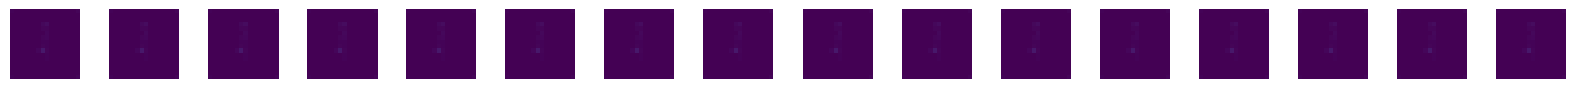

[Epoch 3/100] [D loss: 0.6979] [G loss: 1.1002] [Validity_loss: 0.5083] 
 [Stat_loss: 0.0443] [NNZ_loss: 0.5476]
Sample feature coding: [1.         1.0309246  0.20099783 0.276724   0.50189614 0.01020293
 0.07301447 0.00375293 0.04909834]


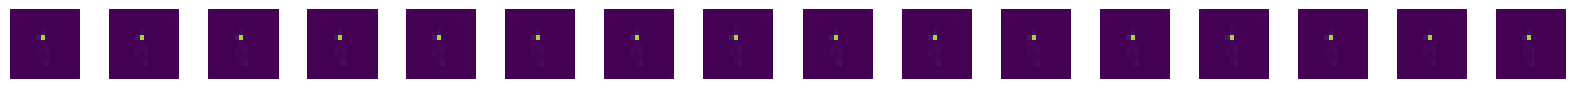

[Epoch 4/100] [D loss: 0.5828] [G loss: 1.3900] [Validity_loss: 0.7897] 
 [Stat_loss: 0.0235] [NNZ_loss: 0.5768]
Sample feature coding: [ 0.         -1.7139856   0.6165902   0.52663344  0.536596    0.00822658
  0.0535692   0.00372541  0.02535205]


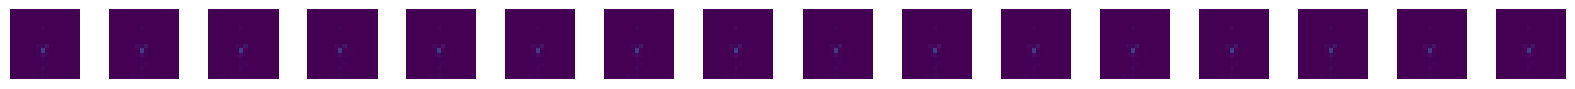

[Epoch 5/100] [D loss: 0.7323] [G loss: 1.0515] [Validity_loss: 0.4034] 
 [Stat_loss: 0.0910] [NNZ_loss: 0.5571]
Sample feature coding: [0.         1.2573959  0.7153217  0.13932621 0.8831571  0.00821542
 0.07782801 0.00327053 0.02621775]


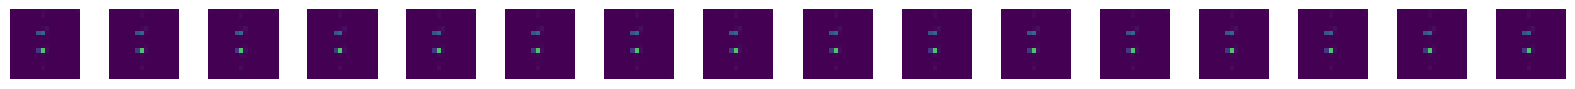

[Epoch 6/100] [D loss: 0.6772] [G loss: 1.1392] [Validity_loss: 0.5628] 
 [Stat_loss: 0.0092] [NNZ_loss: 0.5672]
Sample feature coding: [ 1.         -0.6214514   0.73715365  0.62128776  0.5616108   0.01233214
  0.04477276  0.00392393  0.02626015]


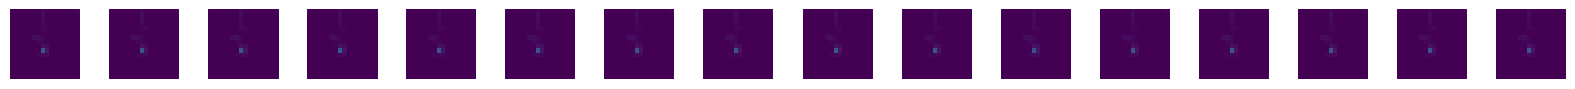

[Epoch 7/100] [D loss: 0.7545] [G loss: 1.5069] [Validity_loss: 0.6383] 
 [Stat_loss: 0.2579] [NNZ_loss: 0.6106]
Sample feature coding: [ 1.         -1.4913303   0.84206235  0.05047639  0.7929896   0.0087247
  0.05811241  0.00392362  0.03766975]


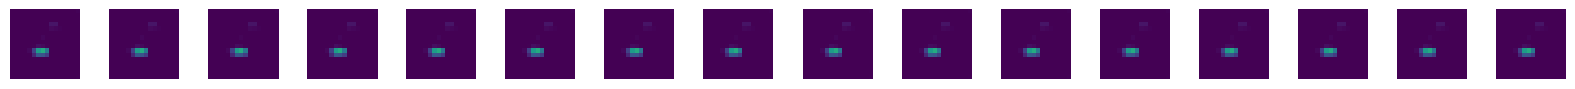

[Epoch 8/100] [D loss: 0.5993] [G loss: 1.2315] [Validity_loss: 0.7269] 
 [Stat_loss: 0.0015] [NNZ_loss: 0.5031]
Sample feature coding: [0.         0.8162577  0.7714253  0.61398643 0.7237565  0.01030396
 0.07030364 0.00399576 0.03167074]


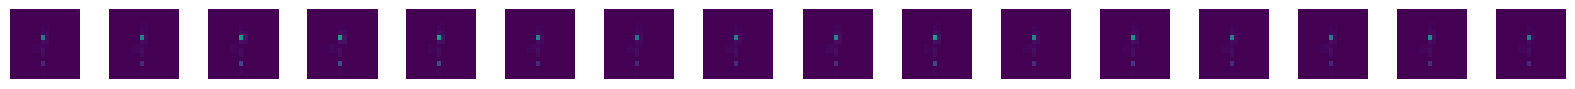

[Epoch 9/100] [D loss: 1.1107] [G loss: 0.9033] [Validity_loss: 0.3717] 
 [Stat_loss: 0.0076] [NNZ_loss: 0.5239]
Sample feature coding: [0.         0.5947688  0.87252504 0.43000317 0.38173172 0.00916056
 0.05954423 0.0036135  0.02408823]


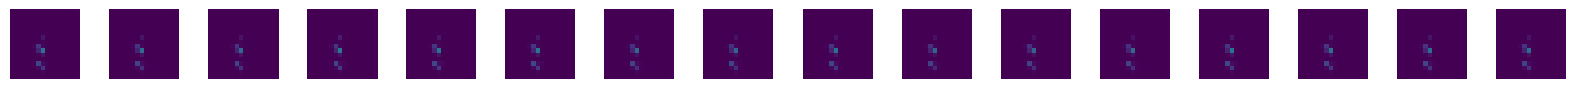

[Epoch 10/100] [D loss: 0.4251] [G loss: 1.5185] [Validity_loss: 0.9289] 
 [Stat_loss: 0.0076] [NNZ_loss: 0.5820]
Sample feature coding: [0.         0.5364993  0.5532399  0.66239387 0.5048618  0.00795482
 0.03183715 0.00376192 0.028155  ]


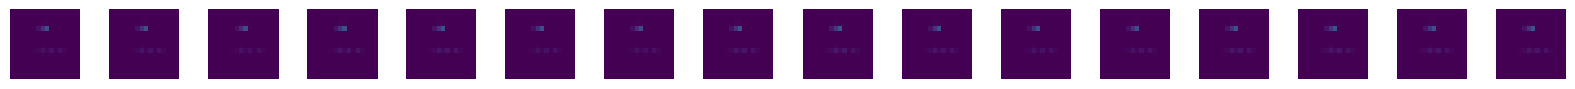

[Epoch 11/100] [D loss: 0.5930] [G loss: 1.2125] [Validity_loss: 0.5496] 
 [Stat_loss: 0.0499] [NNZ_loss: 0.6129]
Sample feature coding: [ 1.         -1.1665082   0.51003164  0.7223377   0.43544495  0.00970106
  0.06549907  0.00418463  0.03367741]


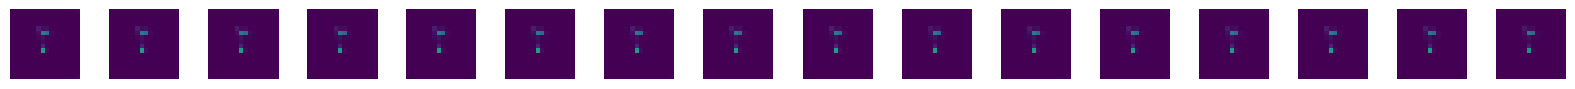

[Epoch 12/100] [D loss: 0.6511] [G loss: 1.2820] [Validity_loss: 0.7401] 
 [Stat_loss: 0.0005] [NNZ_loss: 0.5414]
Sample feature coding: [ 0.         -0.9213253   0.87987     0.64552164  0.49143168  0.01010573
  0.06455173  0.004002    0.01461832]


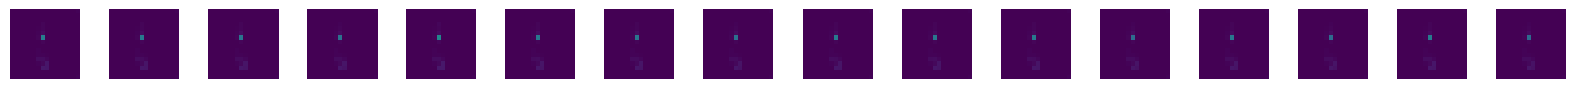

[Epoch 13/100] [D loss: 0.7102] [G loss: 1.0262] [Validity_loss: 0.5176] 
 [Stat_loss: 0.0043] [NNZ_loss: 0.5042]
Sample feature coding: [ 1.         -1.272439    0.37656668  0.4883338   0.8236646   0.00966284
  0.04283908  0.00409895  0.02637651]


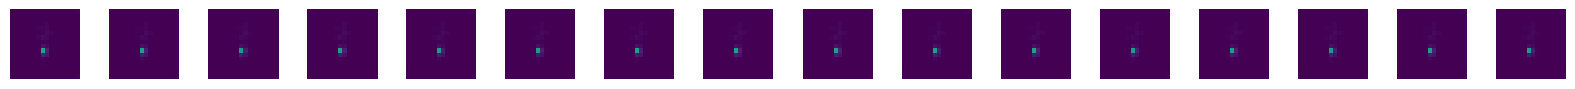

[Epoch 14/100] [D loss: 0.6727] [G loss: 1.0567] [Validity_loss: 0.5799] 
 [Stat_loss: 0.0023] [NNZ_loss: 0.4746]
Sample feature coding: [ 0.         -1.0944355   0.31967923  0.567644    0.40706897  0.00794597
  0.03292281  0.00390911  0.02502255]


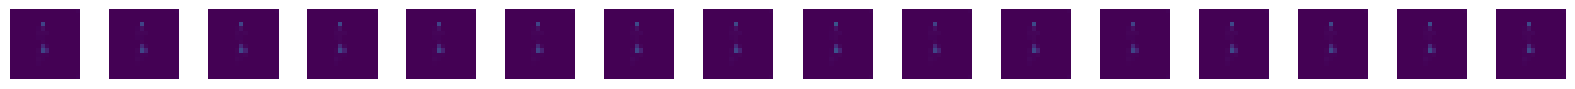

[Epoch 15/100] [D loss: 0.5293] [G loss: 1.2821] [Validity_loss: 0.6753] 
 [Stat_loss: 0.0251] [NNZ_loss: 0.5817]
Sample feature coding: [0.         1.5195408  0.73975104 0.23390834 0.47671434 0.00748272
 0.0474346  0.00386873 0.03282347]


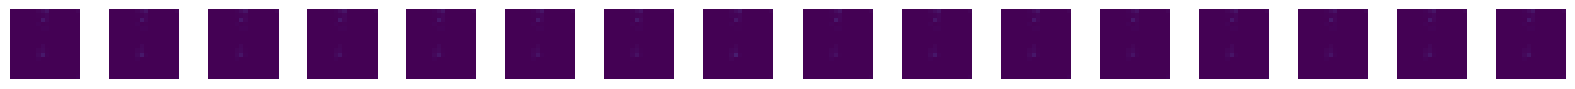

[Epoch 16/100] [D loss: 0.5467] [G loss: 1.3861] [Validity_loss: 0.7707] 
 [Stat_loss: 0.0228] [NNZ_loss: 0.5926]
Sample feature coding: [ 1.         -1.59738     0.77844435  0.50539374  0.5865467   0.00899057
  0.05444141  0.0041681   0.03078152]


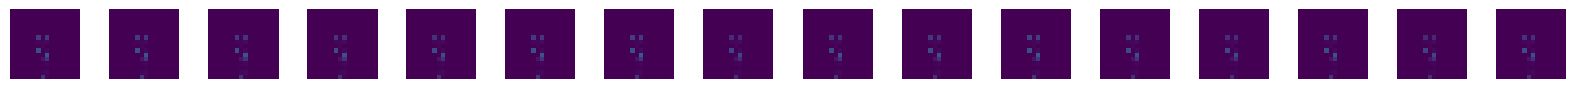

[Epoch 17/100] [D loss: 0.8443] [G loss: 1.0336] [Validity_loss: 0.4788] 
 [Stat_loss: 0.0027] [NNZ_loss: 0.5522]
Sample feature coding: [1.         2.065793   0.5319072  0.5605637  0.5737193  0.01023366
 0.0467526  0.00399719 0.02052455]


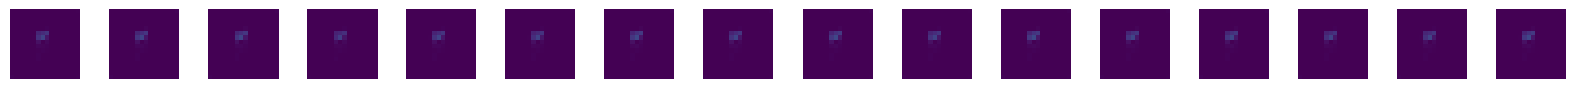

[Epoch 18/100] [D loss: 0.6225] [G loss: 1.2402] [Validity_loss: 0.7496] 
 [Stat_loss: 0.0018] [NNZ_loss: 0.4888]
Sample feature coding: [ 1.         -0.24141149  0.80182433  0.1397662   0.532026    0.0089505
  0.0788528   0.00373555  0.01904355]


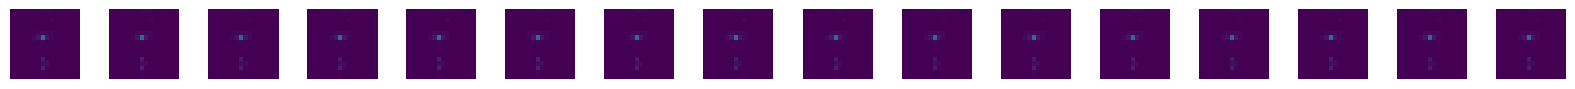

[Epoch 19/100] [D loss: 0.3934] [G loss: 1.4527] [Validity_loss: 0.8337] 
 [Stat_loss: 0.0093] [NNZ_loss: 0.6097]
Sample feature coding: [1.         1.4689891  0.30616772 0.49993464 0.645574   0.00921679
 0.0602549  0.00386627 0.02883366]


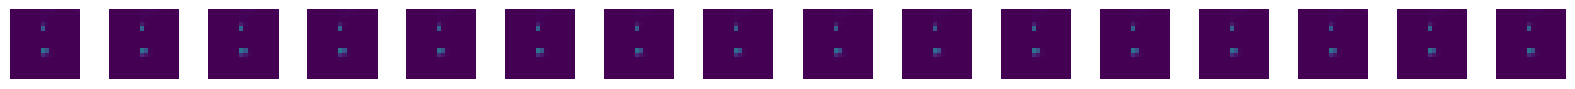

[Epoch 20/100] [D loss: 0.5363] [G loss: 1.0996] [Validity_loss: 0.6468] 
 [Stat_loss: 0.0008] [NNZ_loss: 0.4520]
Sample feature coding: [ 0.         -0.3989537   0.662707    0.45112014  0.63298076  0.00664717
  0.0392993   0.00370518  0.02399199]


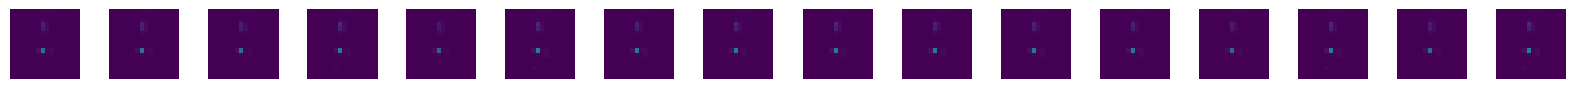

[Epoch 21/100] [D loss: 1.0736] [G loss: 1.1773] [Validity_loss: 0.5438] 
 [Stat_loss: 0.0144] [NNZ_loss: 0.6190]
Sample feature coding: [1.         0.79678535 0.42915332 0.5510745  0.30982205 0.00871428
 0.05014395 0.00352953 0.01264736]


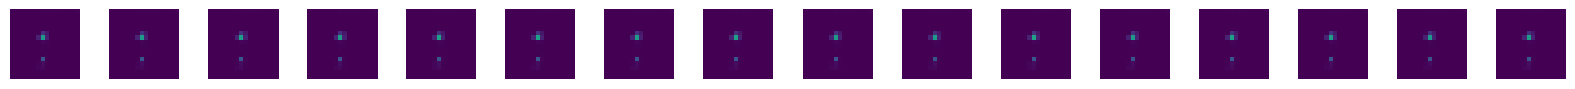

[Epoch 22/100] [D loss: 0.6939] [G loss: 1.3396] [Validity_loss: 0.7511] 
 [Stat_loss: 0.0035] [NNZ_loss: 0.5850]
Sample feature coding: [1.         0.08997825 0.5457615  0.83207005 0.7310678  0.01140894
 0.06462362 0.00360152 0.03469025]


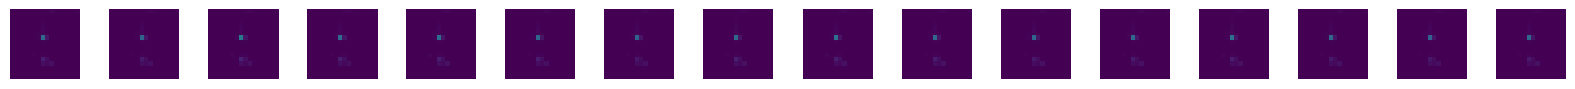

[Epoch 23/100] [D loss: 0.6140] [G loss: 1.4274] [Validity_loss: 0.8876] 
 [Stat_loss: 0.0015] [NNZ_loss: 0.5383]
Sample feature coding: [ 0.         -0.31188795  0.20887166  0.63568705  0.45615253  0.00900847
  0.06775019  0.00398134  0.01951681]


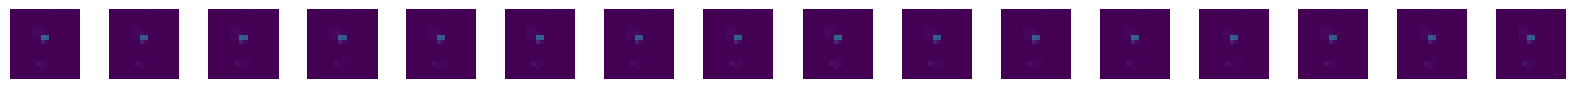

[Epoch 24/100] [D loss: 0.4686] [G loss: 1.5351] [Validity_loss: 0.9832] 
 [Stat_loss: 0.0009] [NNZ_loss: 0.5510]
Sample feature coding: [ 1.         -0.77408063  1.0157766   0.8767794   0.3229729   0.00737968
  0.05105226  0.0038906   0.01568189]


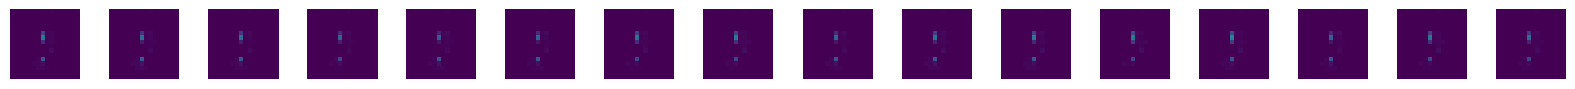

[Epoch 25/100] [D loss: 0.6111] [G loss: 1.0952] [Validity_loss: 0.5841] 
 [Stat_loss: 0.0011] [NNZ_loss: 0.5100]
Sample feature coding: [ 1.         -1.6787018   0.25109208  0.13194221  0.6885229   0.01115055
  0.03218119  0.00401795  0.03647741]


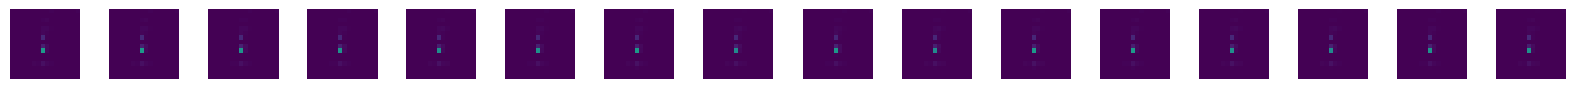

[Epoch 26/100] [D loss: 0.4718] [G loss: 1.4794] [Validity_loss: 0.9144] 
 [Stat_loss: 0.0014] [NNZ_loss: 0.5635]
Sample feature coding: [1.         1.1600523  0.06897439 0.5665974  0.68184733 0.01050204
 0.0693883  0.00402214 0.02604512]


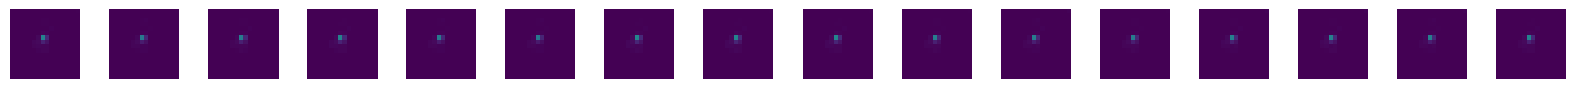

[Epoch 27/100] [D loss: 0.4899] [G loss: 1.3720] [Validity_loss: 0.8329] 
 [Stat_loss: 0.0026] [NNZ_loss: 0.5365]
Sample feature coding: [1.         1.8587792  0.23404726 0.12452805 0.6290378  0.00907511
 0.07566842 0.00381437 0.04138907]


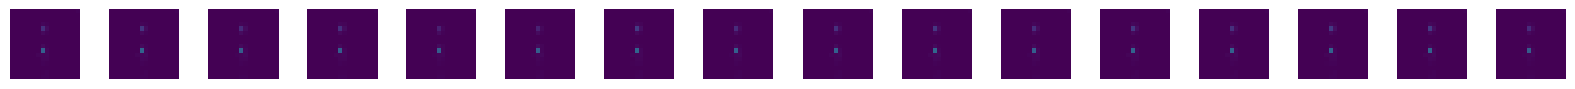

[Epoch 28/100] [D loss: 0.4622] [G loss: 1.5244] [Validity_loss: 0.9386] 
 [Stat_loss: 0.0027] [NNZ_loss: 0.5831]
Sample feature coding: [1.         0.67279357 0.37918937 0.52373236 0.37988946 0.01059204
 0.07086947 0.0038321  0.02411964]


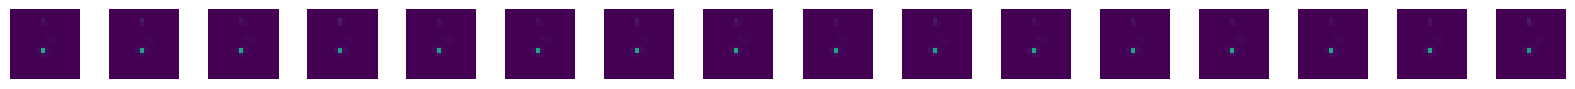

[Epoch 29/100] [D loss: 0.6482] [G loss: 1.4883] [Validity_loss: 0.9295] 
 [Stat_loss: 0.0002] [NNZ_loss: 0.5586]
Sample feature coding: [1.         0.5519021  0.35439363 0.35105294 0.5460662  0.00832413
 0.08468863 0.00372153 0.04250358]


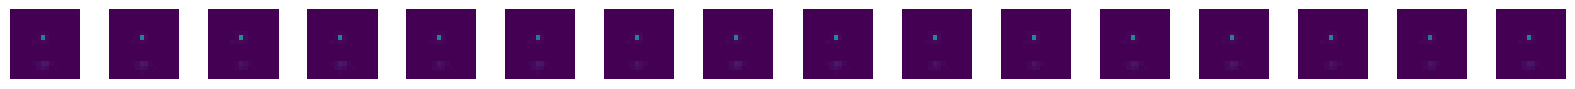

[Epoch 30/100] [D loss: 0.6126] [G loss: 1.0964] [Validity_loss: 0.5613] 
 [Stat_loss: 0.0011] [NNZ_loss: 0.5340]
Sample feature coding: [ 1.         -1.1562054   0.7510642   0.9965742   0.6246798   0.00904611
  0.04562866  0.00381627  0.02268546]


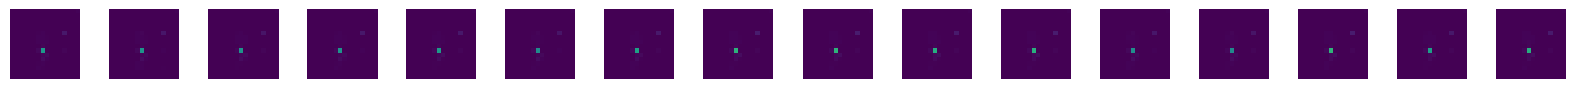

[Epoch 31/100] [D loss: 0.4951] [G loss: 1.6660] [Validity_loss: 1.0800] 
 [Stat_loss: 0.0799] [NNZ_loss: 0.5062]
Sample feature coding: [ 1.         -0.45717615  0.5335935   0.24652943  0.9004838   0.01072961
  0.03562621  0.00388653  0.04310489]


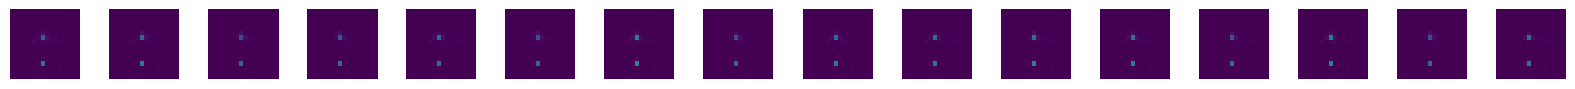

[Epoch 32/100] [D loss: 0.6234] [G loss: 1.2625] [Validity_loss: 0.6590] 
 [Stat_loss: 0.0141] [NNZ_loss: 0.5894]
Sample feature coding: [ 0.         -0.98165494  0.5150043   0.7640754   0.6877536   0.00871287
  0.04729481  0.00382181  0.03148362]


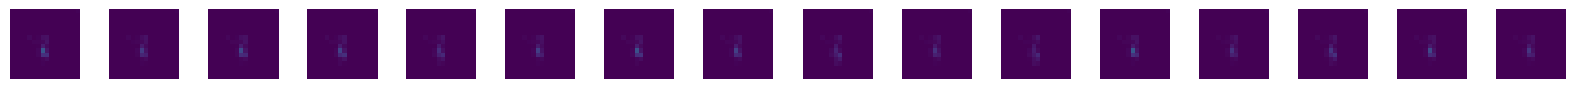

[Epoch 33/100] [D loss: 0.7810] [G loss: 1.0746] [Validity_loss: 0.5199] 
 [Stat_loss: 0.0024] [NNZ_loss: 0.5523]
Sample feature coding: [ 0.         -1.0594736   0.9481416   0.03030223  0.51974225  0.0088895
  0.06595537  0.00393451  0.03641007]


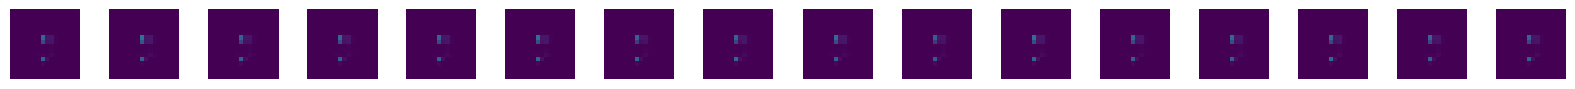

[Epoch 34/100] [D loss: 0.7381] [G loss: 1.4121] [Validity_loss: 0.8225] 
 [Stat_loss: 0.0050] [NNZ_loss: 0.5847]
Sample feature coding: [ 1.         -1.6657548   0.35073555  0.37561253  0.6842786   0.01181612
  0.04115938  0.00354496  0.02654395]


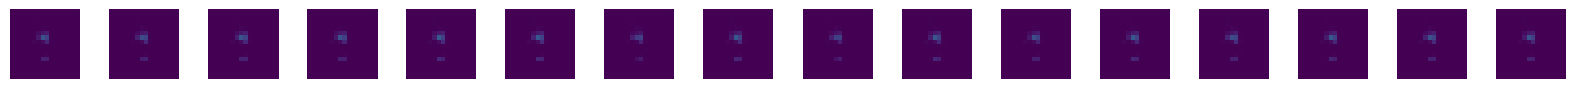

[Epoch 35/100] [D loss: 0.5918] [G loss: 1.2713] [Validity_loss: 0.7703] 
 [Stat_loss: 0.0040] [NNZ_loss: 0.4970]
Sample feature coding: [ 1.         -0.78444827  0.10257568  0.59301376  0.58479697  0.00906401
  0.04438985  0.00359526  0.03246149]


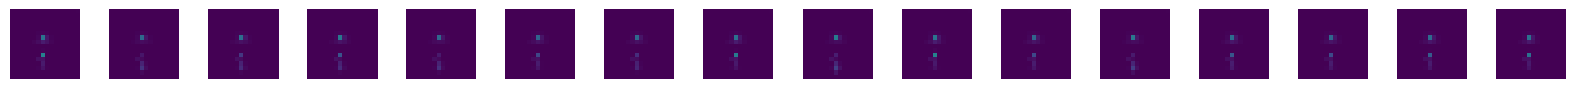

[Epoch 36/100] [D loss: 0.6026] [G loss: 1.3126] [Validity_loss: 0.7842] 
 [Stat_loss: 0.0009] [NNZ_loss: 0.5275]
Sample feature coding: [1.         1.7082888  0.26789367 0.08906971 0.5382239  0.0085988
 0.06970947 0.00403313 0.04621865]


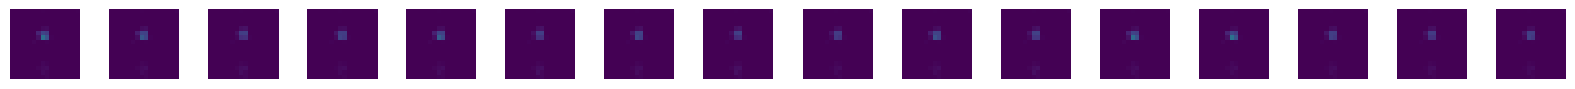

[Epoch 37/100] [D loss: 1.4621] [G loss: 0.9449] [Validity_loss: 0.3868] 
 [Stat_loss: 0.0002] [NNZ_loss: 0.5580]
Sample feature coding: [1.         1.1476414  0.37518686 0.08513463 0.83551854 0.00958864
 0.03450249 0.00377334 0.0347436 ]


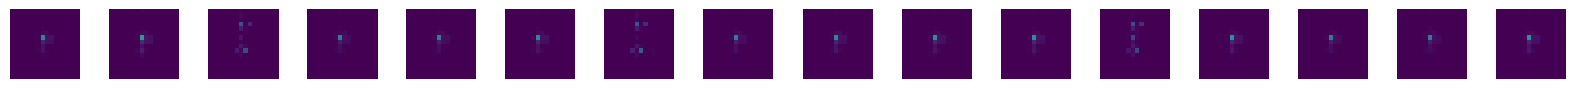

[Epoch 38/100] [D loss: 0.4918] [G loss: 1.3340] [Validity_loss: 0.7175] 
 [Stat_loss: 0.0109] [NNZ_loss: 0.6056]
Sample feature coding: [ 0.         -1.7383153   0.49412176  0.8276295   0.61570203  0.00863128
  0.05316985  0.00369701  0.01392611]


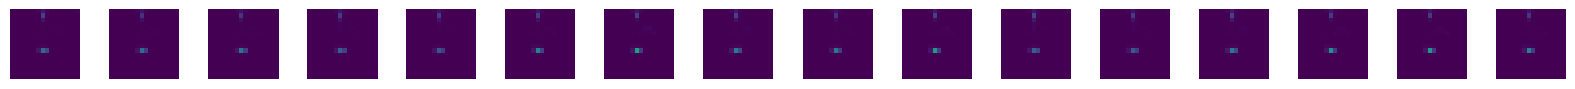

[Epoch 39/100] [D loss: 0.4619] [G loss: 1.4657] [Validity_loss: 0.8902] 
 [Stat_loss: 0.0005] [NNZ_loss: 0.5750]
Sample feature coding: [ 1.         -0.6903972   0.98911554  0.14506337  0.6411368   0.00914919
  0.04992307  0.00371332  0.04428143]


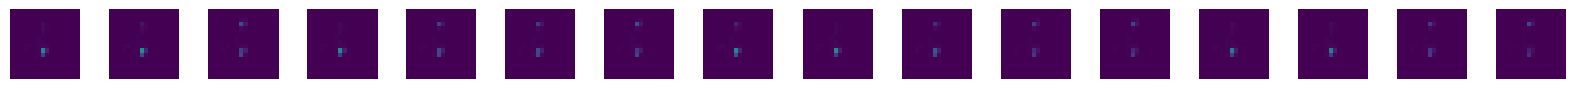

[Epoch 40/100] [D loss: 0.4462] [G loss: 1.4424] [Validity_loss: 0.9530] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.4893]
Sample feature coding: [0.         1.5939413  0.35944894 0.13884811 0.52858824 0.01057844
 0.07414066 0.00367623 0.03125857]


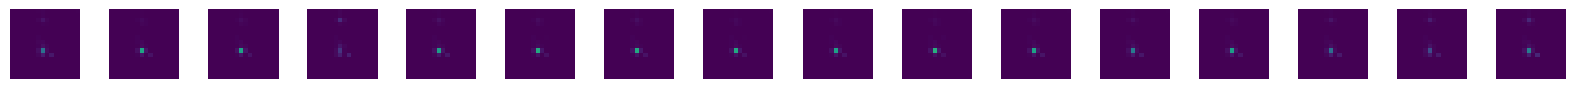

[Epoch 41/100] [D loss: 0.6562] [G loss: 1.3351] [Validity_loss: 0.8168] 
 [Stat_loss: 0.0003] [NNZ_loss: 0.5179]
Sample feature coding: [ 1.         -0.0715302   0.21468027  0.2973346   0.5264966   0.01017654
  0.07401963  0.00347887  0.04186536]


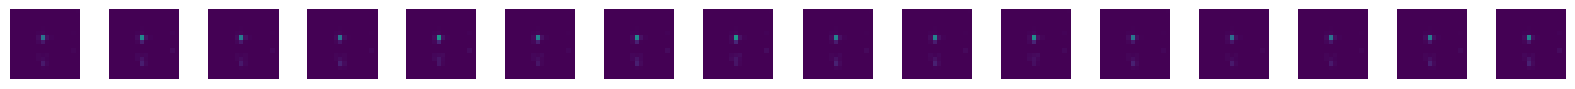

[Epoch 42/100] [D loss: 0.7004] [G loss: 1.3176] [Validity_loss: 0.7898] 
 [Stat_loss: 0.0008] [NNZ_loss: 0.5269]
Sample feature coding: [0.         0.65376264 0.6254154  0.5784906  0.7036902  0.01061381
 0.0622473  0.00371267 0.02801538]


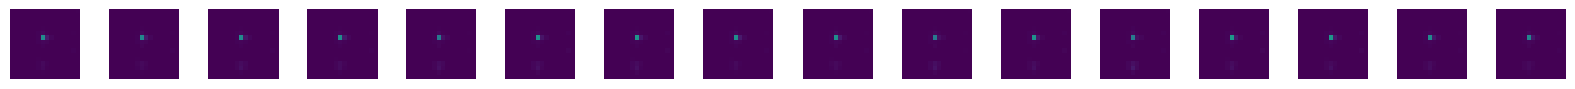

[Epoch 43/100] [D loss: 0.5435] [G loss: 1.3350] [Validity_loss: 0.7646] 
 [Stat_loss: 0.0004] [NNZ_loss: 0.5700]
Sample feature coding: [0.         1.4767565  0.4608637  0.4982025  0.3549005  0.0070051
 0.0356562  0.00353186 0.03768795]


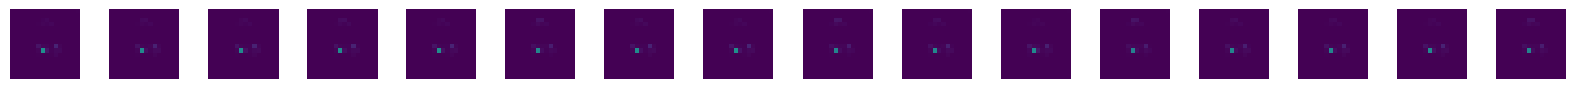

KeyboardInterrupt: 

In [8]:
for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.to(device)
        real_flipped_feat = flipped_features.to(device)
        real_img = real_image.unsqueeze(1).to(device)
        real_flipped_img = flipped_image.unsqueeze(1).to(device)

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values get passed to the generator, then the output image passed to the discriminator

        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).to(device)
            # z_noise = torch.randn(batch_size, 5, ).to(device)
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).to(device)

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).to(device)
            # z_noise = torch.randn(batch_size, 5, ).to(device)
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1

            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)

            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)

            ## Stat loss
            # Compute fake statistics
            fake_stats = compute_fake_statistics(fake_img.to('cpu'), dists.to('cpu'))

            fake_dR_mean = fake_stats['fake_dR_mean'].to(device)
            fake_dR_std = fake_stats['fake_dR_std'].to(device)
            fake_pixel_mean = fake_stats['fake_pixel_mean'].to(device)
            fake_pixel_std = fake_stats['fake_pixel_std'].to(device)
            
            # Get real stats from z_codings (features 5–8)
            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]
            
            real_stats = {
                'real_dR_mean': real_dR_mean,
                'real_dR_std': real_dR_std,
                'real_pixel_mean': real_pixel_mean,
                'real_pixel_std': real_pixel_std
            }
            
            # track_statistics(stats_dict, fake_stats, real_stats)
            # plot_tracked_statistics(stats_dict)
            
            if n_epochs - epoch <= 10:
                # Track the last statistics
                track_statistics(stats_dict, fake_stats, real_stats)

            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl1 = kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / 0.003
            # print(f"KL(real_dR_mean, fake_dR_mean) = {kl1.item()}")
            
            kl2 = kde_kl_divergence_torch(real_dR_std, fake_dR_std) / 0.003
            # print(f"KL(real_dR_std, fake_dR_std) = {kl2.item()}")
            
            kl3 = kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / 0.0025
            # print(f"KL(real_pixel_mean, fake_pixel_mean) = {kl3.item()}")
            
            kl4 = kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / 0.00015
            # print(f"KL(real_pixel_std, fake_pixel_std) = {kl4.item()}")
            
            kl_total = kl1 + kl2 + kl3 + kl4

            stat_loss = kl_total
            
            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .4
            beta = .01
            chi = .01

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[-1]:.4f}] [G loss: {g_losses[-1]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

plot_tracked_statistics(stats_dict)

In [10]:
## Save Model
# Create output directory if it doesn't exist

save = True

if save:
    os.makedirs("models", exist_ok=True)

    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/class_gan_model{timestamp}.pt"
    torch.save({
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_losses": g_losses,
        "d_losses": d_losses,
        "stats_dict": stats_dict
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

Model and statistics saved to models/class_gan_m15_1951.pt


In [ ]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images.min()
vmax = dataset.images.max()
N = dataset.images.shape[0]

# Show images and keep the first imshow object for colorbar
for i in range(n_images):
    n = torch.randint(N, ())
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[n], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

Sample feature coding: [ 0.         -0.42028424  0.82289696  0.7973196   0.57349265  0.00793692
  0.06031863  0.00380348  0.02378194]


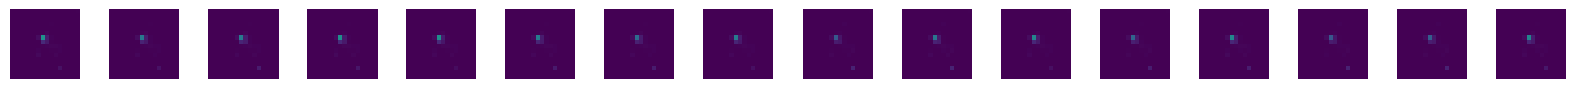

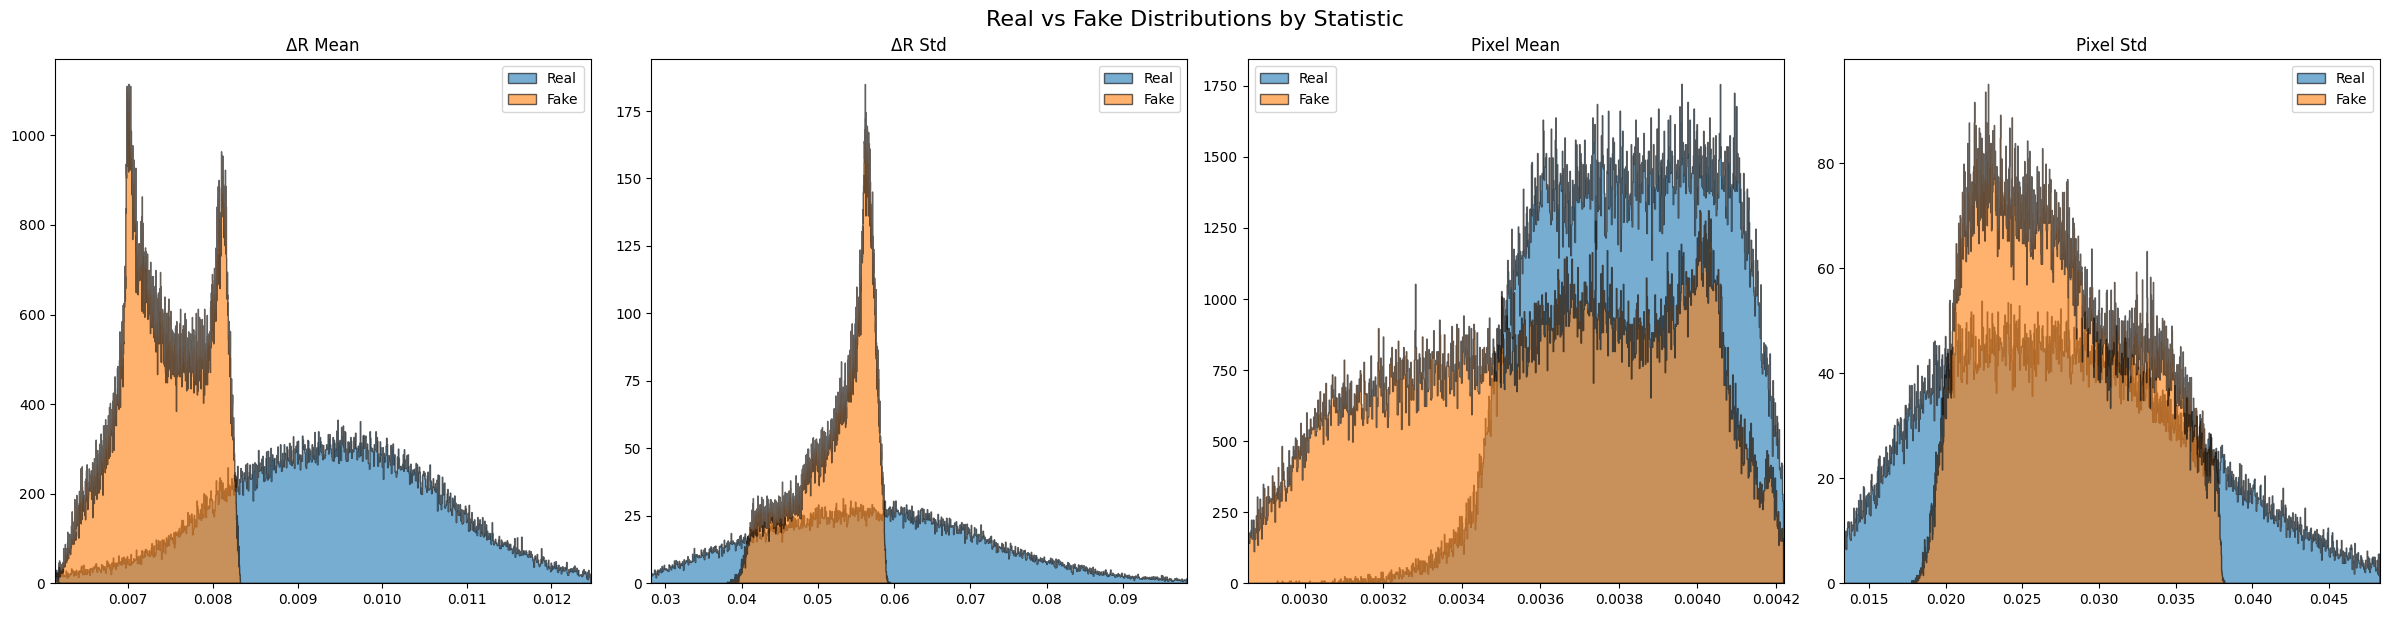

Discriminator output (wrong label): [0.8677921  0.6982462  0.83953947 ... 0.77507645 0.66016144 0.31912643]
Discriminator output (correct label): [0.7311466  0.9071735  0.88308984 ... 0.77507645 0.66016144 0.31912643]
Real labels: [1. 1. 1. ... 0. 0. 0.]
Swapped labels: [0. 0. 0. ... 0. 0. 0.]
Relative change (%): [ 18.689215 -23.030579  -4.931593 ...   0.         0.         0.      ]


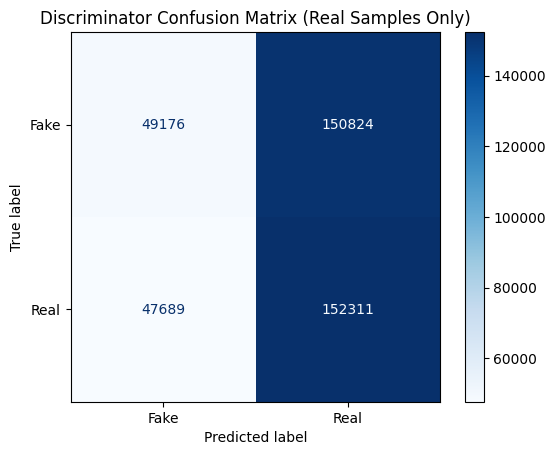

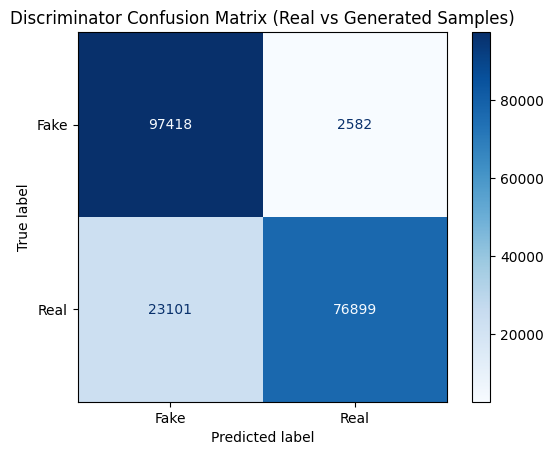

In [12]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True